In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import os

In [89]:
import pickle

In [2]:
import plotly.offline as offline
from plotly.offline import download_plotlyjs
import plotly.graph_objs as go

In [3]:
offline.init_notebook_mode(connected=True)

dataset was obtained from https://data.lacity.org/A-Well-Run-City/Parking-Citations/wjz9-h9np

In [4]:
filepath = os.path.dirname('__filename__')
fp_parking = os.path.join(filepath, 'dataset', 'Parking_Citations.csv') ## Path to dataset

In [ ]:
## Just to see the format of the csv file
# with open(fp_parking, 'r') as f:
#     for n in range(3):
#         line = f.readline()
#         print(line)

In [5]:
df = pd.read_csv(fp_parking, low_memory= False, parse_dates=['Issue Date'])

In [6]:
df.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4038226 entries, 0 to 4038225
Data columns (total 19 columns):
Ticket number            4038226 non-null object
Issue Date               4037801 non-null datetime64[ns]
Issue time               4036941 non-null float64
Meter Id                 1125230 non-null object
Marked Time              141927 non-null float64
RP State Plate           4037223 non-null object
Plate Expiry Date        3686011 non-null float64
VIN                      16309 non-null object
Make                     4034020 non-null object
Body Style               4034392 non-null object
Color                    4036234 non-null object
Location                 4037672 non-null object
Route                    4011489 non-null object
Agency                   4037798 non-null float64
Violation code           4038226 non-null object
Violation Description    4037860 non-null object
Fine amount              4033923 non-null float64
Latitude                 4038226 non-null fl

## Find/Fix Errors

### Ticket Number

In [7]:
## The column with mix column types
df.columns[[0]]

Index(['Ticket number'], dtype='object')

In [8]:
## One of the example why parsing Ticket number resulted in mix dtype
print("Example of Ticket number's parse error: {}".format(df.loc[595827, 'Ticket number']))
print("Number of parse errors: {}".format(\
    pd.to_numeric(df['Ticket number'], errors='coerce').isna().sum())) ## Count fail conversions

Example of Ticket number's parse error: 1107495524D
Number of parse errors: 150


In [9]:
## Delete the letter D from number and convert to int value
## astype to make sure every row is treated as a string
df['Ticket number'] = pd.to_numeric(df['Ticket number'].astype('str')
                                    .str.replace('D', ''), downcast = 'unsigned')

In [10]:
## Make sure that ticket numbers are all unique
tmp = df.duplicated(subset='Ticket number', keep = False)
print('Number of Ticket number duplicates: {}'.format(tmp.sum()))

Number of Ticket number duplicates: 8


In [11]:
df[tmp].sort_values(by = 'Ticket number')

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
1907370,1107505044,2015-04-12,1525.0,NaN,NaN,CA,201506.0,NaN,FORD,SU,BK,B-79 OUTER PKG LOT,M78,3.0,8709K,PK OVR PNTD LNS,58.0,99999.0,99999.0
1978540,1107505044,2015-04-30,2136.0,46,NaN,CA,201507.0,NaN,TOYO,PA,WH,122 N KINGSLEY DR,NaN,54.0,8058L,PREF PARKING,68.0,99999.0,99999.0
1968362,1107505055,2015-04-30,2147.0,46,NaN,CA,201507.0,NaN,FORD,TR,WH,200 N HOBART BL,NaN,54.0,8058L,PREF PARKING,68.0,99999.0,99999.0
2003185,1107505055,2015-04-21,1125.0,NaN,NaN,CA,NaN,NaN,HRI,TL,BK,500 N LECOUVREUR AVE,M78,3.0,80691A,COMM TRAILER/22 FT.,78.0,6483992.8,1740936.0
1285397,1111163222,2015-01-06,1655.0,NaN,NaN,CA,201501.0,NaN,CADI,PA,BK,10851 W OHIO AVE,00123,51.0,8069AP,NO STOP/STAND PM,93.0,6428251.9,1842411.5
1908101,1111163222,2015-04-17,646.0,NaN,NaN,CA,201502.0,NaN,HOND,PA,SI,3405 S OVERLAND AV,00146,51.0,8069C,PKD OVER TIME LIMIT,58.0,6436653.8,1832101.2
1037436,1112203050,2016-06-05,1700.0,NaN,NaN,CA,201604.0,NaN,HOND,PA,GY,7610 WOODLEY AVE,2C12,11.0,5204A,EXPIRED TAGS,25.0,6415432.1,1898663.3
1062722,1112203050,2016-06-19,319.0,NaN,NaN,CA,201601.0,NaN,KIA,PA,WH,301 WORLD WAY,3F93,2.0,4000A1,NO EVIDENCE OF REG,50.0,6437963.6,1802392.9


Cannot find reasons for duplicate ticket number and since duplicates are such a small population and I have no good reason to correct them at the moment, I will keep them as is. 

## Issue Date

In [12]:
df['Issue Date'].describe()

count                 4037801
unique                   1292
top       2016-01-19 00:00:00
freq                     9829
first     2010-01-09 00:00:00
last      2017-10-31 00:00:00
Name: Issue Date, dtype: object

In [13]:
## Count number of tickets by year
df['Issue Date'].dt.year.value_counts().sort_index()

2010.0         12
2011.0         10
2012.0         30
2013.0         38
2014.0      39406
2015.0    2181331
2016.0    1783038
2017.0      33936
Name: Issue Date, dtype: int64

This does not look right at all. There are too little tickets for all years but 2015 and 2016 which I have verified by other's analysis on the dataset. https://public.tableau.com/profile/amit.n6941#!/vizhome/ParkinginLosAngeles2016/Dashboard1 

## VIN

In [14]:
## VIN column isn't that useful because it is mainly null so keep as string
print("The number of non-null for VIN column: {:d}".format(df['VIN'].notnull().sum()))

The number of non-null for VIN column: 16309


## Issue Time

In [15]:
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df['Issue time'].describe())

count   4036941
mean       1224
std         477
min           0
25%         923
50%        1207
75%        1545
max        2359
Name: Issue time, dtype: float64


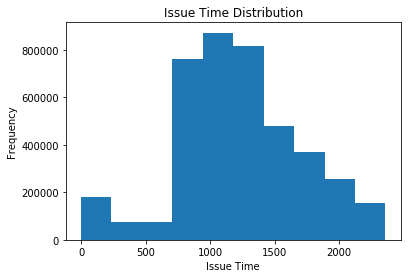

In [16]:
df['Issue time'].plot(kind = 'hist')
plt.title('Issue Time Distribution')
plt.xlabel('Issue Time')
plt.show()

Issue Time looks fine. There are no obvious wrong values. 

In [17]:
## Determine if Issue Time is truly a float or because of NaN
print("Number of floats: {}".format(sum(df['Issue time']%1 > 0)))
print('Number of nan: {}'.format(df['Issue time'].isna().sum()))

Number of floats: 0
Number of nan: 1285


In [18]:
## Remove nan from Issue Time by setting it to -1
df.loc[df['Issue time'].isna(),'Issue time'] = -1

## Meter Id

In [19]:
print('The number of unique meter ids: {}'.format(len(df['Meter Id'].unique())))

The number of unique meter ids: 34973


In [20]:
## Not sure if these are weird meter id
meter_count = df.groupby('Meter Id').size()
meter_count = pd.DataFrame(meter_count)
meter_count.reset_index(inplace = True)
meter_count.columns = ['Meter Id', 'count']
meter_count[:5]

,Meter Id,count
0,!!,1
1,#1,284
2,#18,1
3,#2,604
4,#23,2


In [21]:
## Found meter information 
## https://data.lacity.org/A-Well-Run-City/Parking-Meters-Citywide/sijn-eyig
## However it's for 2015 and last updated on 11/29/2016 so outdated
fp_meter = os.path.join(filepath, 'dataset', 'LADOT_Meters_Citywide_20151209.csv') ## Path to dataset
meter = pd.read_csv(fp_meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34718 entries, 0 to 34717
Data columns (total 6 columns):
ADDRESS     34718 non-null object
METERID     34718 non-null object
LIMIT       34138 non-null object
the_geom    34718 non-null object
TYPE        34718 non-null object
HOURS       34316 non-null object
dtypes: object(6)
memory usage: 1.6+ MB


In [22]:
meterid = pd.DataFrame(meter.METERID.unique())
meterid.columns = ['Meter Id']
meterid['exist'] = True ## Indicator

In [23]:
## Full join with meter from parking citation with meter id from meter data
meter_exist = pd.merge(meter_count, meterid, how= 'outer')

In [24]:
## Return meters that doesn't exist in the meter dataset
meter_prob = meter_exist[meter_exist.exist.isna()].sort_values(by = 'count')[::-1]
print(meter_prob.shape[0])
## Find meter with the most count
meter_prob.head()

3124


,Meter Id,count,exist
355,37,23324.0,NaN
436,51,15400.0,NaN
450,53,13705.0,NaN
511,64,10918.0,NaN
117,13,10854.0,NaN


In [25]:
df[df['Meter Id'] == '37'].head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude
1413,4272294585,2016-01-04,1806.0,37,NaN,AZ,201604.0,NaN,FORD,PA,GY,1666 SYCAMORE AVE N,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6457731.2,1859366.8
1415,4272294600,2016-01-04,2156.0,37,NaN,CA,NaN,NaN,TOYT,PA,WT,7000 HAWTHORN AVE,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6458312.4,1859071.2
1417,4272294622,2016-01-04,2205.0,37,NaN,CA,201608.0,NaN,LEXS,PA,BK,1666 SYCAMORE AVE N,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6457731.2,1859366.8
1419,4272294644,2016-01-04,2216.0,37,NaN,CA,201604.0,NaN,FORD,PA,MR,1601 ORANGE DR,00402,54.0,80.58L,PREFERENTIAL PARKING,68.0,6458315.2,1858662.1
2721,4273416265,2016-01-04,1806.0,37,NaN,NV,201610.0,NaN,VOLK,PA,BK,1633 NORTH ORANGE DRIVE,00401,54.0,80.58L,PREFERENTIAL PARKING,68.0,6458312.4,1859071.2


In [26]:
df[df['Meter Id'] == '37'].Location.unique().shape

(1907,)

It doesn't look like meter id is a very reliable source because the ID and addresses do not match. In fact for Meter Id 37 there is 1907 different addresses. So for now, just leave it as is. 

## Marked Time

In [27]:
df[df['Marked Time'].notnull()]['Violation Description'].unique()

array(['PARKED OVER TIME LIM', 'PREFERENTIAL PARKING',
       'COMM VEH OVER TIME L', 'PARKED OVER TIME LIMIT'], dtype=object)

So Marked Time means the acutal Time car marked was marked to determine how long the car was in that parking spot.

In [107]:
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df['Marked Time'].describe())

count   141927
mean      1068
std        226
min          1
25%        925
50%       1042
75%       1205
max       2400
Name: Marked Time, dtype: float64


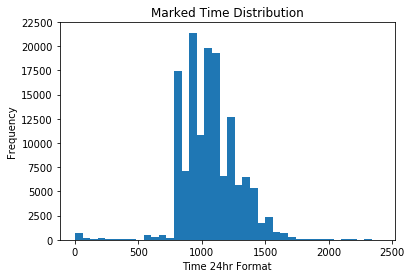

In [111]:
df.loc[df['Marked Time'].notnull(), 'Marked Time'].plot(kind = 'hist', bins = 40)
plt.title('Marked Time Distribution')
plt.xlabel('Time 24hr Format')
plt.show()

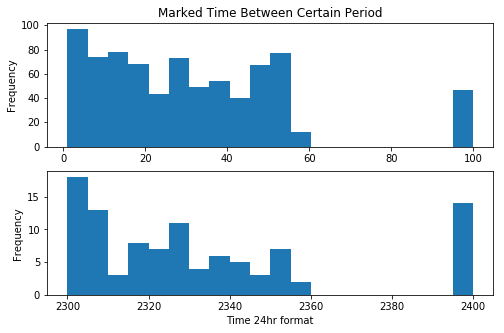

In [121]:
plt.figure(figsize = (8, 5))
plt.subplot(2, 1, 1)
df.loc[df['Marked Time'].between(0, 100), 'Marked Time'].plot.hist(bins = 20)
plt.title('Marked Time Between Certain Period')

plt.subplot(2, 1, 2)
df.loc[df['Marked Time'].between(2300,2400), 'Marked Time'].plot.hist(bins = 20)
plt.xlabel('Time 24hr format')
plt.show()

In [161]:
## How many are 2400. Parse time will be NaT
print('Number of values at 2400: {}'.format(sum(df['Marked Time'] == 2400)))
## Fix time to 2359
df.loc[df['Marked Time'] == 2400, 'Marked Time'] = 2359

Number of values at 2400: 14


In [215]:
# ## A round about way because column was import as float
# tmp_time = df['Marked Time'].copy()
# ## Remove nan to convert to int to remove decimal
# tmp_time[tmp_time.isna()] = -1
# ## Add 0 padding so that 24 hour format is consistent
# tmp_time = tmp_time.astype('int').astype('str').str.pad(4, 'left', '0')
# ## Verify times are correct
# tmp_time[tmp_time != '00-1'].head()
# df['Marked Time'] = pd.to_datetime(tmp_time, errors='coerce', format = '%H%M').dt.time
# df.loc[df['Marked Time'].notnull(), 'Marked Time'].head()

In [221]:
## Convert NaN into -1 as to save space
df.loc[df['Marked Time'].isna(), 'Marked Time'] = -1

I am not sure if I should convert time into datetime because subtracting 23:00 with 01:00 would yield 22:00 which is incorrect because 11pm - 1am shold be 2 hours. 

## RP State Plate

In [30]:
state_plate = pd.DataFrame(df.groupby('RP State Plate').size().sort_values())
state_plate.reset_index(inplace = True)
state_plate.columns = ['state', 'number']
state_plate.head(3)

,state,number
0,|,2
1,PR,5
2,NF,5


In [31]:
## USA States and Territories
states = {"AL":"Alabama","AK":"Alaska","AS":"American Samoa","AZ":"Arizona","AR":"Arkansas",
          "CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware",
          "DC":"District Of Columbia","FM":"Federated States Of Micronesia","FL":"Florida",
          "GA":"Georgia","GU":"Guam","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana",
          "IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine",
          "MH":"Marshall Islands","MD":"Maryland","MA":"Massachusetts","MI":"Michigan",
          "MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska",
          "NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York",
          "NC":"North Carolina","ND":"North Dakota","MP":"Northern Mariana Islands","OH":"Ohio",
          "OK":"Oklahoma","OR":"Oregon","PW":"Palau","PA":"Pennsylvania","PR":"Puerto Rico",
          "RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota","TN":"Tennessee",
          "TX":"Texas","UT":"Utah","VT":"Vermont","VI":"Virgin Islands","VA":"Virginia",
          "WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"}
states = pd.DataFrame.from_dict(states, orient = 'index')
states.reset_index(inplace = True)
states.columns = ['abbr', 'name']
states.head(3)

,abbr,name
0,AL,Alabama
1,AK,Alaska
2,AS,American Samoa


In [32]:
## State Plate that doesn't exist in states list
state_comb = pd.merge(state_plate, states, how = 'outer', left_on='state', right_on='abbr')
state_unknown = state_comb[state_comb.name.isna()]
state_unknown[['state', 'number']]

,state,number
0,|,2.0
2,NF,5.0
3,YU,7.0
4,PE,9.0
5,NW,9.0
7,TT,12.0
10,CZ,22.0
11,NS,46.0
12,XX,54.0
13,SA,73.0


I think MX is Mexico plate because LA is pretty close to Mexico so it is possible and likely for cars to come to LA. Or a misspelling for MS because s is close to x on the keyboard. 

In [33]:
tmp = state_comb[~(state_comb.abbr.isna() | state_comb.state.isna())].copy()
tmp.loc[tmp.state == 'CA', 'number'] = 0 ## Remove California because majority from there
tmp.sort_values(by = 'number')[::-1][1:10] ## Top 10 without CA

,state,number,abbr,name
73,TX,25806.0,TX,Texas
72,NV,24677.0,NV,Nevada
71,FL,16767.0,FL,Florida
70,WA,15995.0,WA,Washington
69,IL,11906.0,IL,Illinois
68,OR,10859.0,OR,Oregon
67,CO,10133.0,CO,Colorado
66,NY,7782.0,NY,New York
65,PA,6040.0,PA,Pennsylvania


In [34]:
## The bottom 4 are far away US's territories
state_comb[~(state_comb.abbr.isna() | state_comb.state.isna())].sort_values(by = 'number').head(4)

,state,number,abbr,name
1,PR,5.0,PR,Puerto Rico
6,AS,11.0,AS,American Samoa
8,VI,16.0,VI,Virgin Islands
9,GU,20.0,GU,Guam


In [35]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [dict(type = 'choropleth',
             colorscale = scl,
             autocolorscale = False,
             locations = tmp.state,
             z = tmp.number,
             locationmode = 'USA-states',
             marker = dict(line = dict(color = 'rgb(255,255,255)', width = 2)),colorbar = dict(title = 'Number of Cars'))]

layout = dict(title = 'Number of Tickets By State (without CA)',
             geo = dict(scope = 'usa',
                       projection = dict(type = 'albers usa'),
                       showlakes = True,
                       lakecolor = 'rgb(255,255,255)'))

fig = dict(data = data, layout = layout)
offline.plot(fig, config={'displayModeBar': False, 'showLink': False}, filename="image/ticket_state.html")

'file://C:\\Users\\boki\\Desktop\\project\\2018_la_parking_citation\\image\\ticket_state.html'

Judging from the map, it looks like each states are independent and do not look like they are impacted from the distance it is from California. So MX is most likely Mexico? 

In [36]:
## Total tickets from unknow states
state_unknown.number.sum()

8147.0

Because the combined unkown states' tickets account for a small amount and it is hard to guess what the correct spelling was suppose to be, so I will rename them as **UNKNOWN**. In addition, the amount for the state can change dramastically like BC could've been misspelling of NC but that would increase the total amount by 30%+, some state are even more impacted. 

In [37]:
df.loc[df['RP State Plate'].isin(state_unknown.state.values), 'RP State Plate'] = 'UNKNOWN'

In [154]:
## Export summary of RP State PLate
df['RP State Plate'].value_counts().to_csv('dataset/state_clean.csv')

## Plate Expiry Date

In [38]:
## There are clearly mislabeled dates
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df['Plate Expiry Date'].describe())

count   3686011
mean     184909
std       55524
min           1
25%      201508
50%      201603
75%      201609
max      624103
Name: Plate Expiry Date, dtype: float64


In [39]:
## A list of valid possible dates
valid_dates = [str(year) + month for year in range(2000,2025) 
               for month in ['01','02','03','04','05','06','07','08','09','10','11','12']]
valid_dates = pd.Series(valid_dates, dtype = 'int')

In [40]:
## Invalid Expiration isnt from 2010 to 2019 and not NaN
not_valid = ~(df['Plate Expiry Date'].isin(valid_dates) | df['Plate Expiry Date'].isna())
not_valid.sum()

309447

In [41]:
not_valid_count = df.loc[not_valid, 'Plate Expiry Date'].astype('int').value_counts(dropna=False).sort_values()[::-1]
not_valid_count[not_valid_count > 100]

9         33723
1         28045
11        27546
2         25928
6         25842
4         25141
8         24968
7         24734
3         23736
5         23028
10        22421
12        19756
201500      490
201700      462
201600      337
201800      172
201215      128
200615      124
200915      112
200815      111
200316      110
201115      102
Name: Plate Expiry Date, dtype: int64

It looks like majority of the mistakes are because it is missing the year. Because we know that registration is usually renewed every year and it is less likely for someone to get a ticket the same month it was just renewed, we can just add the same year that the car got the ticket. 

It is harder to guess the other ones and they amount to a smaller population so I will just turn them into NaN. 

In [42]:
## Find the index of rows where the value is between 1 and 12
month_index = df['Plate Expiry Date'].between(1,12)

In [43]:
## Add year to month such that the format is YYYYMM
df.loc[month_index, 'Plate Expiry Date'] = df.loc[month_index, 'Issue Date'].dt.year*100 \
                                                + df.loc[month_index, 'Plate Expiry Date']

In [44]:
tmp2 = df.loc[month_index, 'Issue Date'].dt.year*100 \
                                                + df.loc[month_index, 'Plate Expiry Date']

In [45]:
## Current number of invalid and nan date format
sum(~(df['Plate Expiry Date'].isin(valid_dates)))

356794

In [46]:
## Convert all invalid dates and nan into zeros
df.loc[~(df['Plate Expiry Date'].isin(valid_dates)), 'Plate Expiry Date'] = 0

In [47]:
## Convert Plate Expiry Date into correct datetime type 
df['Plate Expiry Date'] = pd.to_datetime(df['Plate Expiry Date'].astype('int')\
                                         .astype('str'), errors='coerce', format = '%Y%m')

In [48]:
df['Plate Expiry Date'].describe()

count                 3681432
unique                    270
top       2016-06-01 00:00:00
freq                   166879
first     2000-01-01 00:00:00
last      2024-11-01 00:00:00
Name: Plate Expiry Date, dtype: object

## Violation Code + Violation Description

In [49]:
## Rename string to new value in Violation Description
def rename_des(to_replace, value):
    df['Violation Description'].replace(to_replace = to_replace, 
                                        value = value, inplace = True)

In [50]:
## The number of violation code and description
print('Number of unique code: {}'.format(df['Violation code'].unique().size))
print('Number of unique description: {}'.format(df['Violation Description'].unique().size))

Number of unique code: 263
Number of unique description: 498


In [51]:
## Remove punctuations which causes a lot of different codes
df['Violation code'] = df['Violation code'].str.replace('[.+#*-]', '')
print('Number of unique code reduce to: {}'.format(df['Violation code'].unique().size))
## Remove * and make text upper case for more consistent with each other
df['Violation Description'] = df['Violation Description'].str.replace('*', '').str.upper()
print('Number of unique description reduce to: {}'.format(df['Violation Description'].unique().size))

Number of unique code reduce to: 195
Number of unique description reduce to: 495


In [52]:
## Match code and descriptions but sort by description
df.groupby(['Violation code', 'Violation Description'])\
    .size().reset_index().sort_values(by = 'Violation Description')\
    .to_csv('dataset/v_code_desc_pre_clean.csv')

In [53]:
## Are are a lot of violation code and violation description that just misspelling or 
## different code so it seems like a good idea to make code and description more consistent. 
## In addition some of the description are actually violation code. 

## Description Corrections:

## PARKED OVER TIME LIM --> PARKED OVER TIME LIMIT
rename_des('PARKED OVER TIME LIM', 'PARKED OVER TIME LIMIT')
## BLK BIKE PATH OR LANE --> BLOCKING BIKE PATH/LANE ## For consistency 
## BLK BIKE PATH OR LAN --> BLOCKING BIKE PATH/LANE
rename_des(['BLK BIKE PATH OR LAN', 'BLK BIKE PATH OR LANE'], 'BLOCKING BIKE PATH/LANE')
## BLOCKING INTERSECTIO --> BLOCKING INTERSECTION
rename_des('BLOCKING INTERSECTIO', 'BLOCKING INTERSECTION')
## CATERING/W/I 200 FT --> CATERING VIOLATION  ## There are only 1
rename_des('CATERING/W/I 200 FT', 'CATERING VIOLATION')
## COMM VEH OVER TIME L --> COMM VEH OVER TIME LIMIT
## COMVEH RES/OV TM B-2 --> COMM VEH OVER TIME LIMIT  ## Account for a small population
## COMVEH RES/OV TM C-3 --> COMM VEH OVER TIME LIMIT  ## Account for a small population
## COMVEH RES/OV TM LMT --> COMM VEH OVER TIME LIMIT  ## Account for a small population
rename_des(['COMM VEH OVER TIME L', 'COMVEH RES/OV TM B-2', 
            'COMVEH RES/OV TM C-3', 'COMVEH RES/OV TM LMT'], 
           'COMM VEH OVER TIME LIMIT')
## DISABLED PARKING/BOU --> DISABLED PARKING/BOUNDARIES
## HANDICAP/ON LINE --> DISABLED PARKING/BOUNDARIES ## Same code
## HANDICPD/ON LINE --> DISABLED PARKING/BOUNDARIES ## Same code
rename_des(['DISABLED PARKING/BOU', 'HANDICAP/ON LINE', 'HANDICPD/ON LINE'], 
           'DISABLED PARKING/BOUNDARIES')
## DISABLED PARKING/CRO --> DISABLED PARKING/CROSS HATCH
## HANDICAP/CROSS HATCH --> DISABLED PARKING/CROSS HATCH  ## Same code
rename_des(['DISABLED PARKING/CRO', 'HANDICAP/CROSS HATCH'], 
           'DISABLED PARKING/CROSS HATCH')
## DISABLED PARKING/NO --> DISABLED PARKING/NO DP ID
## HANDICAP/NO DP ID --> DISABLED PARKING/NO DP ID
rename_des(['DISABLED PARKING/NO', 'HANDICAP/NO DP ID'], 
           'DISABLED PARKING/NO DP ID')
## HANDICPD/BLOCKING --> DISABLED PARKING/OBS 
## DISABLED PARKING/OBS --> DISABLED PARKING/BLOCKING  ## More descriptive title
rename_des(['HANDICPD/BLOCKING', 'DISABLED PARKING/OBS'], 
           'DISABLED PARKING/BLOCKING')
## EXCEED 72HRS-ST --> EXCEED 72 HOURS
rename_des('EXCEED 72HRS-ST', 'EXCEED 72 HOURS')
## LOADING ZONES --> LOAD/UNLOAD ONLY  ## Only 1
rename_des('LOADING ZONES', 'LOAD/UNLOAD ONLY')
## METER EXP. --> METER EXPIRED  ## Same Code 
## METER OFFENSE --> METER EXPIRED  ## Only 1
rename_des(['METER EXP.', 'METER OFFENSE'], 
           'METER EXPIRED')
## NO PARK STRT CLEAN --> NO PARK/STREET CLEAN
rename_des('NO PARK STRT CLEAN', 'NO PARK/STREET CLEAN')
## NO PARKING BETWEEN P --> NO PARKING BETWEEN POSTED HOURS
rename_des('NO PARKING BETWEEN P', 'NO PARKING BETWEEN POSTED HOURS')
## NO STOPPING/ANTI-GRI --> NO STOPPING/ANTI-GRIDLOCK ZONE
rename_des('NO STOPPING/ANTI-GRI', 'NO STOPPING/ANTI-GRIDLOCK ZONE')
## OFF STREET/OVERTIME --> OFF STR/OVERTIME/MTR
rename_des('OFF STREET/OVERTIME', 'OFF STR/OVERTIME/MTR')
## PARK IN XWALK --> PARKED IN CROSSWALK 
rename_des('PARK IN XWALK', 'PARKED IN CROSSWALK')
## PARKED OVER TIME LIM --> PARKED OVER TIME LIMIT
## PK BYND TM LMTS --> PARKED OVER TIME LIMIT  ## Same code
## PKD OVER TIME LIMIT --> PARKED OVER TIME LIMIT  ## Same code
rename_des(['PARKED OVER TIME LIM', 'PK BYND TM LMTS', 'PKD OVER TIME LIMIT'], 
           'PARKED OVER TIME LIMIT')
## Combined since they mean the same
## OUTSIDE MARKER --> PARKED OUTSIDE SPACE ## Same meaning and only 5 cases
## PK OVR PNTD LNS --> PARKED OUTSIDE SPACE ## Same meaning and has 75 cases
rename_des(['OUTSIDE MARKER', 'PK OVR PNTD LNS'], 
           'PARKED OUTSIDE SPACE')
## PARKING/FRONT YARD 1 --> PARKING/FRONT YARD  ## Same code
## PARKING/FRONT YARD 2 --> PARKING/FRONT YARD  ## Same code
## PARKING/FRONT YARD 3 --> PARKING/FRONT YARD  ## Same code
rename_des(['PARKING/FRONT YARD 1', 'PARKING/FRONT YARD 2', 'PARKING/FRONT YARD 3'], 
           'PARKING/FRONT YARD')
## PK OVERSIZED 1ST --> PK OVERSIZ  ## Same code
## PK OVERSIZED 2ND --> PK OVERSIZ  ## Same code
## PK OVERSIZED 3RD --> PK OVERSIZ  ## Same code
## PK OVERSIZ --> PARK OVERSIZED  ## More descriptive title
rename_des(['PK OVERSIZED 1ST', 'PK OVERSIZED 2ND', 
            'PK OVERSIZED 3RD', 'PK OVERSIZ'], 
           'PARK OVERSIZED')
## PK TRAILER 2 --> PK TRAILER ## Same code
rename_des('PK TRAILER 2', 'PK TRAILER')
## PREF PARKING --> PREFERENTIAL PARKING
rename_des('PREF PARKING', 'PREFERENTIAL PARKING')
## PRKG PUBL GRNDS --> PARKING PUBLIC GROUNDS
## PUBLIC GROUNDS --> PARKING PUBLIC GROUNDS
rename_des(['PRKG PUBL GRNDS', 'PUBLIC GROUNDS'], 
           'PARKING PUBLIC GROUNDS')
## RESTRICTED ZONE --> RESTRICTED TAXI ZONE ## Same code
rename_des('RESTRICTED ZONE', 'RESTRICTED TAXI ZONE')
## SIGN POSTED - NO PAR --> SIGN POSTED - NO PARK ## Same code
## SIGN PSTD-NO PK --> SIGN POSTED - NO PARK ## Same code
## SIGN POSTED - NO PARK --> PARKED IN POSTED AREA ## Same meaning
rename_des(['SIGN POSTED - NO PAR', 'SIGN PSTD-NO PK'], 'PARKED IN POSTED AREA')
## STANDNG IN ALLEY --> STANDING IN ALLEY 
## STNDNG IN ALLEY --> STANDING IN ALLEY
rename_des(['STANDNG IN ALLEY', 'STNDNG IN ALLEY'], 'STANDING IN ALLEY')

In [54]:
## Description most likely means the same thing:

## RED CURB --> RED ZONE
rename_des('RED CURB', 'RED ZONE')
## WHITE CURB --> WHITE ZONE
rename_des('WHITE CURB', 'WHITE ZONE')
## YELLOW CURB --> YELLOW ZONE
rename_des('YELLOW CURB', 'YELLOW ZONE')

In [55]:
## Cluster violation code together 
tmp = df[['Violation code', 'Violation Description']].copy()
## Find index for which violation code's length is smaller than 3
tmp2 = df['Violation code'].str.len() <= 3 
## Transfer code from description to code column
tmp.loc[tmp2, 'Violation code'] = tmp.loc[tmp2, 'Violation Description']
## Group code and description sorted by code to match code and description together
tmp.groupby(['Violation code', 'Violation Description']).size()\
    .reset_index().sort_values('Violation code')\
    .to_csv('dataset/v_code_desc_clean1.csv')
del tmp, tmp2

In [56]:
## Fix Description where violation code instead of text or same code different Description
## A few are educated guess  
## A lot are ignored due to missing/additional letter/integer
## because the code are not well structed
## Some every have same description different code or the reverse
## used v_code_des.csv

## Description Correction: 

## 17104C --> R/PRIV PARKING AREA
rename_des('17104C', 'R/PRIV PARKING AREA')
## 17104H --> LOAD/UNLOAD ONLY
rename_des('17104H', 'LOAD/UNLOAD ONLY')
## 21113A --> PARKING PUBLIC GROUNDS
rename_des('21113A', 'PARKING PUBLIC GROUNDS')
## PARK FIRE LANE --> PARKED IN FIRE LANE
rename_des('PARK FIRE LANE', 'PARKED IN FIRE LANE')
## 22500A --> WITHIN INTERSECTION
rename_des('22500A', 'WITHIN INTERSECTION')
## 22500B --> PARKED IN CROSSWALK
rename_des('22500B', 'PARKED IN CROSSWALK')
## 22500C --> SAFETY ZONE/CURB
rename_des('22500C', 'SAFETY ZONE/CURB')
## 22500D --> PK-15FT FIRE ST
rename_des('22500D', 'PK-15FT FIRE ST')
## 22500E --> BLOCKING DRIVEWAY
rename_des('22500E','BLOCKING DRIVEWAY')
## 22500F --> PARKED ON SIDEWALK
rename_des('22500F', 'PARKED ON SIDEWALK')
## 22500G --> OBSTR EXCAVATN
rename_des('22500G', 'OBSTR EXCAVATN')
## 22500H --> DOUBLE PARKING
## 22500H1 --> DOUBLE PARKING ## Only 1 case and usually means the same
rename_des(['22500H', '22500H1'], 'DOUBLE PARKING')
## 22500I --> PARKED IN BUS ZONE
rename_des('22500I', 'PARKED IN BUS ZONE')
## 22500J --> PARKNG IN TUNNEL
rename_des('22500J', 'PARKNG IN TUNNEL')
## 22500K --> PARKED ON BRIDGE
rename_des('22500K', 'PARK ON BRIDGE')
## DP-BLKNG ACCESS RAMP --> DISABLED PARKING/BLOCK ACCESS RAMP ## More Descriptive title
## BLOCK HANDICAP ACCES --> DISABLED PARKING/BLOCK ACCESS RAMP
rename_des(['DP-BLKNG ACCESS RAMP', 'BLOCK HANDICAP ACCES'], 
           'DISABLED PARKING/BLOCK ACCESS RAMP')
## 22502A --> 18 IN/CURB/2 WAY
## 18 IN. CURB/2 WAY --> 18 IN/CURB/2 WAY ## For consistency
rename_des(['22502A', '18 IN. CURB/2 WAY'], '18 IN/CURB/2 WAY')
## 22502E --> 18 IN. CURB/1 WAY 
## 18 IN. CURB/1 WAY --> 18 IN/CURB/1 WAY
rename_des(['22502E', '18 IN. CURB/1 WAY'], '18 IN/CURB/1 WAY')
## DISABLED PARKING/BOUNDARIES --> DISABLED PARKING/CROSS HATCH
rename_des('DISABLED PARKING/BOUNDARIES', 'DISABLED PARKING/CROSS HATCH')
## 225111A --> PARKED IN ELEC VEHIC  
rename_des('225111A', 'PARKED IN ELEC VEHIC')
## 2251156 --> DP-REFUSE ID 
## DP-REFUSE ID --> DISABLED PARKING/REFUSE ID ## Most likely description
rename_des(['2251156', 'DP-REFUSE ID'], 'DISABLED PARKING/REFUSE ID')
## DP-ALTERED --> DP- RO NOT PRESENT
## DP-SUBPLATE --> DP- RO NOT PRESENT
## 2251157B --> DP- RO NOT PRESENT
## 2251157A --> DP- RO NOT PRESENT ## Most likely description
## 2251157C --> DP- RO NOT PRESENT ## Most likely description
## DP- RO NOT PRESENT --> DISABLED PARKING/RO NOT PRESENT ## More Descriptive Title
rename_des(['DP-ALTERED', 'DP-SUBPLATE', '2251157B', 
            '2251157A', '2251157C', 'DP- RO NOT PRESENT'], 
           'DISABLED PARKING/RO NOT PRESENT')
## 22514 --> FIRE HYDRANT
rename_des('22514', 'FIRE HYDRANT')
## 22515 --> UNATT/MOTOR ON
rename_des('22515', 'UNATT/MOTOR ON')
## 22522 --> 3 FT. SIDEWALK RAMP
rename_des('22522', '3 FT. SIDEWALK RAMP')
## 22523A --> ABAND VEH/HIGHWAY
rename_des('22523A', 'ABAND VEH/HIGHWAY')
## 22526 BLK INT PROHIB --> 22526A BLOCKING INTERSECTION ## Most likely the same
rename_des('BLK INT PROHIB', 'BLOCKING INTERSECTION')
## 4000A = 4000A1 ## Most likely the same
## 40001A = 4000A1 ## Most likely the same and is only 10 cases
## 4000A --> NO EVIDENCE OF REG
## 40001A --> NO EVIDENCE OF REG
rename_des(['4000A', '40001A'], 'NO EVIDENCE OF REG')
## 5200 --> DISPLAY OF PLATES 
## 5200A1 --> DSPLYPLATE A ## Most likely the same
## DSPLYPLATE A --> DISPLAY OF PLATES # Most likely the same
## DSPLYPLATE B --> DISPLAY OF PLATES # Most likely the same
rename_des(['5200', '5200A1', 'DSPLYPLATE A', 'DSPLYPLATE B'],
          'DISPLAY OF PLATES')
## NO PK BET 1-3AM --> NO PARK/BETWEEN POSTED HOURS
## NO PARKING BETWEEN POSTED HOURS --> NO PARK/BETWEEN POSTED HOURS ## For consistency
rename_des(['NO PK BET 1-3AM', 'NO PARKING BETWEEN POSTED HOURS'], 
           'NO PARK/BETWEEN POSTED HOURS')
## Combine, No Idea what description means
## PARKING OUTSIDE PARK --> PARKING OUTSIDE PARK STL
## PK OUTSD PK STL --> PARKING OUTSIDE PARK STL
rename_des(['PARKING OUTSIDE PARK', 'PK OUTSD PK STL'],
          'PARKING OUTSIDE PARK STL')
## PKD IN/ON PARKWAY --> PARKED IN PARKWAY
rename_des('PKD IN/ON PARKWAY', 'PARKED IN PARKWAY')
## 80581 --> CARSHARE PARKING
## CARSHARE PARKING --> PARKING IN CARSHARE ## For consistency 
rename_des(['80581', 'CARSHARE PARKING'], 'PARKING IN CARSHARE')
## 80691A --> COMM TRAILER/22 FT.
## COMM TRAILER/22 FT. --> TRAILER COMM/22 FT ## For consistency 
rename_des(['80691A', 'COMM TRAILER/22 FT.'], 'TRAILER COMM/22 FT')
## PARKING UNHITCHED TR --> TRAILER PARKING UNHITCHED ## For consistency
## PK TRAILER --> TRAILER PARKING UNHITCHED 
rename_des(['PARKING UNHITCHED TR', 'PK TRAILER'], 
          'TRAILER PARKING UNHITCHED')
## 8069AA NO STOP/STAND --> NO STOP/STAND AM
df.loc[df['Violation code'] == '8069AA', 
       'Violation Description'] = 'NO STOP/STAND AM'
## 8069AP NO STOP/STANDING --> NO STOP/STAND PM
df.loc[df['Violation code'] == '8069AP', 
       'Violation Description'] = 'NO STOP/STAND PM'
## 8069A NO STOPPING/STANDING --> NO STOP/STAND ## For consistency 
## 8069A STOP/STAND PROHIBIT --> NO STOP/STAND
## 89391A STOP/STAND PROHB --> NO STOP/STAND
df.loc[df['Violation code'].isin(['8069A', '89391A']), 
       'Violation Description'] = 'NO STOP/STAND'
## TRAILER   6' HIGH --> VEH/LOAD OVR 6' HIGH 
## VEH/LOAD OVR 6' HIGH --> VEH/LOAD OVR 6FT ## For consistency
rename_des(["TRAILER   6' HIGH", "VEH/LOAD OVR 6' HIGH"], "VEH/LOAD OVR 6FT")
## PARK IN GRID LOCK ZN --> NO STOP/ANTI-GRIDLOCK ZONE
## NO STOPPING/ANTI-GRIDLOCK ZONE --> NO STOP/ANTI-GRIDLOCK ZONE ## For consistency
rename_des(['PARK IN GRID LOCK ZN', 'NO STOPPING/ANTI-GRIDLOCK ZONE'], 
           'NO STOP/ANTI-GRIDLOCK ZONE')
## 8603 CITY PARK/PROHIB --> PARKED IN PROHIBITED AREA
## PK IN PROH AREA --> PARKED IN PROHIBITED AREA  ## For consistency 
## PARK RESTRCD --> PARKED IN PROHIBITED AREA ## Most likely the same
df.loc[df['Violation code'] == '8603', 
       'Violation Description'] = 'PARKED IN PROHIBITED AREA'
rename_des('PARK RESTRCD', 'PARKED IN PROHIBITED AREA')
## 8606 CITY PARK/PROHIB --> PARKED OUTSIDE POSTED AREA
## PK OTSD PSTD AR --> PARKED OUTSIDE POSTED AREA ## For consistency 
df.loc[df['Violation code'] == '8606', 
       'Violation Description'] = 'PARKED OUTSIDE POSTED AREA'
## PK NR FIRE HYDR --> FIRE HYDRANT ## Only 2 case, diff code, but most likely the same 
rename_des('PK NR FIRE HYDR', 'FIRE HYDRANT')
## TM LMT EXCEEDED --> EXCEED TIME LMT ## Only 1 case, diff code, but most likely the same
## EXCEED TIME LMT --> PARKED OVER TIME LIMIT ## Has the same meaning
rename_des(['TM LMT EXCEEDED', 'EXCEED TIME LMT'], 'PARKED OVER TIME LIMIT')
## 8709B --> PARK-PSTD AREAS
## 6344K8 SIGN POSTED - NO PARK --> PARK-PSTD AREAS ## Similar meaning
## PARK-PSTD AREAS --> PARKED IN POSTED AREA ## For consistency 
rename_des(['8709B', 'PARK-PSTD AREAS', 'SIGN POSTED'], 'PARKED IN POSTED AREA')
## 8709H PK OVR 2 SPACES --> PARK OVERSIZED ## Only 9 cases, diff code, but most likely the same
## 8940B PK OVR 2 SPACES --> PARK OVERSIZED ## Only 3 cases, diff code, but most likely the same
## 22507A OVERSIZED VEHICLE PA --> PARK OVERSIZED ## Most likely the same
rename_des(['PK OVR 2 SPACES', 'OVERSIZED VEHICLE PA'], 'PARK OVERSIZED')
## 8753 --> MOB BILBD ADV DISP 
rename_des('8753', 'MOB BILBD ADV DISP')
## 8755 --> FOR SALE SIGN 
rename_des('8755', 'FOR SALE SIGN')
## 8803 PARKING OUTSIDE OF S --> 8803 METER/OUTSIDE LINES
## 8803A PK OUTSD SPACE --> 8803A METER/OUTSIDE LINES
## OUTSIDE LINES/METER --> METER/OUTSIDE LINES ## For consistency
## 8853 PK OUTSD SPACE --> 8853 OFF STR MTR/OUT LINE
## 8853 OFF STR MTR/OUT LINE --> METER/OUTSIDE LINES ## Same meaning
df.loc[df['Violation code'].isin(['8803', '8803A', '8853']), 
       'Violation Description'] = 'METER/OUTSIDE LINES'
## FAIL DEP COIN --> NO COIN DEP IN METER ## Most likely the same 
## NO COIN DEP IN METER --> METER/EXPIRED
## 8863B 8864B OFF STR/OVERTIME/MTR --> METER EXPIRED 
## METER EXPIRED --> METER/EXPIRED ## For consistency 
rename_des(['FAIL DEP COIN', 'NO COIN DEP IN METER', 
            'OFF STR/OVERTIME/MTR', 'METER EXPIRED'],
          'METER/EXPIRED')

In [57]:
## Simple rename of description: 

## MORE 18-CURB --> 18 IN/CURB ## For consistency 
rename_des('MORE 18-CURB', '18 IN/CURB')
## CLOSED MT FIRE RD --> MT FIRE RD CLOSED ## For consistency 
rename_des('CLOSED MT FIRE RD', 'MT FIRE RD CLOSED')
## OBST FIRE RD --> MT FIRE RD OBST ## For consistency
rename_des('OBST FIRE RD', 'MT FIRE RD OBST')
## BLK RAIL PROHIB --> BLOCKING RAIL ## More Descriptive Title 
rename_des('BLK RAIL PROHIB', 'BLOCKING RAIL')
## MISUSE/DP PRIVILEGE --> DISABLED PARKING/MISUSE PRIVILEGE  ## More Descriptive Title
rename_des('MISUSE/DP PRIVILEGE', 'DISABLED PARKING/MISUSE PRIVILEGE')
## NO PARKING --> NO PARK ## For consistency 
## PARKING PROHIB --> NO PARK ## For consistency 
## TEMPORARY NO PARKING --> NO PARK ## Only 1 case and same meaning
rename_des(['NO PARKING', 'PARKING PROHIB', 'TEMPORARY NO PARKING'], 'NO PARK')
## ILGL EXT OF TM --> ILLEGAL EXTENSION OF TIME 
rename_des('ILGL EXT OF TM', 'ILLEGAL EXTENSION OF TIME')
## PARKNG IN TUNNEL --> PARKED IN TUNNEL
rename_des('PARKNG IN TUNNEL', 'PARKED IN TUNNEL')
## PK TRLR-PUBL AR --> TRAILER PARKED IN PUBLIC AREA
rename_des('PK TRLR-PUBL AR', 'TRAILER PARKED IN PUBLIC AREA')
## STATE HIGHWAY PARKNG --> PARKED ON STATE HIGHWAY ## For consistency
rename_des('STATE HIGHWAY PARKNG', 'PARKED ON STATE HIGHWAY')
## PK ON PRIV ST --> PARKED ON PRIVATE STREET ## Very few cases and are kind of the same
## R/PRIV PARKING AREA --> PARKED ON PRIVATE PROPERTY # Has ~3% of cases and are kind of the same
## PRIVATE PROPERTY --> PARKED ON PRIVATE PROPERTY ## This accounts for ~97% of cases
rename_des(['PK ON PRIV ST', 'R/PRIV PARKING AREA', 'PRIVATE PROPERTY'], 
           'PARKED ON PRIVATE PROPERTY')
## PK-15FT FIRE ST --> PARKED 15FT FIRE ST ## Not sure what this is
rename_des('PK-15FT FIRE ST', 'PARKED 15FT FIRE ST')
## PREFERENTIAL PARKING --> PARKED IN PREFERENTIAL PARKING
rename_des('PREFERENTIAL PARKING', 'PAKRED IN PREFERENTIAL PARKING')
## PRK FLOOD CNTL CHANL --> PARKED ON FLOOD CONTROL CHANNEL
rename_des('PRK FLOOD CNTL CHANL', 'PARKED ON FLOOD CONTROL CHANNEL')
## 3 FT. SIDEWALK RAMP --> PARKED WITHIN 3FT SIDEWALK RAMP
rename_des('3 FT. SIDEWALK RAMP', 'PARKED WITHIN 3FT SIDEWALK RAMP')
## PARKING/FRONT YARD --> PARKED ON FRONT YARD
rename_des('PARKING/FRONT YARD', 'PARKED ON FRONT YARD')

**Same violation code but mix meaning **

Example:

* 5204A = DISPLAY OF TABS = EXPIRED TAGS?
* 8049 = 18 IN/CURB/COMM VEH = WRG SD/NOT PRL (Wrong standard distance/not parallel?)

In [58]:
## Export csv for another inspection
df.groupby('Violation Description').size().reset_index().to_csv('dataset/v_code_desc_clean2.csv')

In [59]:
## Turn violation description that are still in code form into UNKNOWN 
## NON-code has more than 3 letters in them 
tmp = df['Violation Description'].astype('str').str.count('[A-Z]') <= 3
## Replace code from description to code column
df.loc[tmp, 'Violation code'] = df.loc[tmp, 'Violation Description']
## Convert description's code rows into UNKNOWN
df.loc[tmp, 'Violation Description'] = 'UNKNOWN'
print('Number of UNKNOWN: {}'.format(tmp.sum()))
del tmp

Number of UNKNOWN: 3467


In [60]:
## Groupby Violation code and Violation Description and count cases
df.groupby(['Violation code','Violation Description']).size()\
    .to_csv('dataset/v_code_des_final.csv')

In [61]:
## Groupby Violation Description and count cases
df.groupby('Violation Description').size().to_csv('dataset/v_des_final.csv')

Violation Description was reduce to 120 unique values and have 3467 UNKNOWN values. 

**Violation code is left as is except when the code was in the description column so there are still rows where the value do have meaning like 0, 11, 13, 9.**

## Make

In [62]:
print('Number of unique Make: {}'.format(df.Make.unique().shape[0]))

Number of unique Make: 1086


It would be very difficult to fix this feature because of the nature of how the information is inputed. 

Car make seems to be shorten based on personal perference, car commonly accepted abbreviation, or by guessing. For instance:

* ACURA could be ACUR, ACC, ACCU, ACUA
* AUDI could be AUD, AUDI
* TOYOTA could be TOYO, TOYT

Single letter difference can be totally different car: For instance: 

* BENZ (Mercedes Benz) != BENT (Bentley) 
* VOLV (Volvo) != VOLK (Volkswagen) 

Also hard to guess car brand since there is no set list and brands come and go and my limited knowledge.

In [63]:
## Educated Guess 

## Brand Name == ABBR (total count)
## TOYOTA == TOYO (39180) == TOYT(668496)
## Because most common brand 
df.Make.replace('TOYO', 'TOYT', inplace=True)
## LEXUS == LEXS (115760) == LEXU (6425) == LEX (33)
df.Make.replace(['LEXU', 'LEX'], 'LEXS', inplace=True)
## MINI == MNNI (28749) == MINI (1205) == MIN (10)
## Most likely typo
df.Make.replace(['MNNI', 'MIN'], 'MINI', inplace=True)
## ISUZU == ISUZ (426) == ISU (8716)
df.Make.replace('ISU', 'ISUZ', inplace=True)
## Volkswagon == VOLK (145314) == VW (159)
df.Make.replace('VW', 'VOLK', inplace=True)
## KAWASAKI == KW (2423) == KAWK (1471) == KAWA (87)
df.Make.replace(['KAWA', 'KAWK'], 'KW', inplace=True)
## MERCEDES-BENZ == BENZ (163219) == MBNZ (3463) == MBZ (20)
df.Make.replace(['MBNZ', 'MBZ'], 'BENZ', inplace=True)
## SUZUKI == SUZI (6413) == SUZU (426)
df.Make.replace('SUZU', 'SUZI', inplace=True)
## MITSUBISHI == MITZ (58) == MITS (38021)
df.Make.replace('MITZ', 'MITS', inplace=True)
## TESLA == TSLA (21) == TESL (148)
df.Make.replace('TSLA', 'TESL', inplace=True)
## DODGE RAM == RAM (10) == DODG (116641)
df.Make.replace('RAM', 'DODG', inplace=True)
## HYUNDAI == HYUN(116542),HD(2076),HYND(8),HYD(8),HYDA(2),HYDI(2)
df.Make.replace(['HD', 'HYND', 'HYD', 'HYDA', 'HYDI'], 
                'HYUN', inplace=True)
## FIAT == FIAT (14603) == FIA (2)
df.Make.replace('FIA', 'FIAT', inplace=True)
## Probaby means Other == OTHE(22) == OTHR(72581)
df.Make.replace('OTHE', 'OTHR', inplace = True)

In [64]:
## Count each car make after cleaning 
df.groupby('Make').size().sort_values()[::-1].to_csv('dataset/make_final.csv')

## Body Style

In [65]:
df['Body Style'].unique()

array(['PA', 'TR', 'TL', nan, 'VN', 'PU', 'CM', 'TK', 'SU', 'UT', 'MC',
       'MH', 'MS', 'OT', 'BU', 'RV', '4D', 'TT', 'LM', 'VV', 'CH', 'TC',
       'TW', 'LI', 'SW', 'JE', 'CC', 'CO', 'TX', 'ZV', 'PY', 'TA', 'PP',
       '2D', 'CA', 'SH', 'SC', '2', 'MN', 'BO', 'JU', 'VA', '20', 'SV',
       'U', 'BX', 'W', 'TZ', 'QV', 'SE', 'GY', 'Z', '4', 'HS', '4W', 'RD',
       'UH', 'TO', 'MO', 'Q', 'R', 'RU', 'VC', 'TN', 'AM', 'BI', 'BN',
       'TE', 'S', 'MV', 'DE', 'G', 'HC', 'PT', 'WG', 'CP', 'HB', 'BK',
       'PM', 'UK', 'VW', '4H', 'FB', 'CV', 'UN', 'FE', 'H', 'LE', 'WA',
       'HM', 'MT', 'MU', 'ZX', '1', 'XT', 'PO', 'GC', 'AC', '16', '11',
       'J', 'ET', 'MD', 'HO', 'C0', 'CN', 'SD', 'CR', 'JP', 'Y', 'CW',
       'UP', 'CE', 'N', '38'], dtype=object)

There isn't enough information in the features themselves for me to infer there meaning. Therefore, I can only leave as is. 

## Color

In [66]:
df.Color.unique()

array(['GN', 'WT', 'SL', 'BK', 'GY', 'BL', 'SI', 'GO', 'CR', 'WH', 'RE',
       'BN', 'RD', 'TN', 'MR', 'PR', 'OT', 'TA', 'GR', 'MA', 'OR', 'RU',
       'BR', nan, 'BU', 'YE', 'PU', 'BG', 'UN', 'TU', 'CO', 'PK', 'PL',
       'BE', 'SN', 'PE', 'BZ', 'PI', 'ME', 'CH', 'TE', 'LI', 'MU', 'KH',
       'GA', 'AQ', 'WI', 'OL', 'SA', 'KA', 'RS', 'CL', 'TP', 'PW', 'SU',
       'CP', 'UT', 'SH', 'OG', 'UK', 'VI', 'BW', 'RV', 'YL', 'TW', 'GD'], dtype=object)

Not enough information to confidently infer actual color type. 

## Agency

In [67]:
print(np.sort(df.Agency.unique()))
print('Number of NaN: {}'.format(df.Agency.isna().sum()))

[  1.   2.   3.   4.   5.   6.   7.   9.  11.  12.  13.  16.  24.  34.  35.
  36.  38.  40.  41.  42.  43.  45.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  68.  77.  97.  nan]
Number of NaN: 428


In [68]:
## Fill NaN as 0 before integer conversion
df.Agency.fillna(value = 0, inplace = True)
## Convert column into integer
df['Agency'] = pd.to_numeric(df['Agency'], downcast='unsigned').astype('str')
print('Number of NaN: {}'.format(df.Agency.isna().sum()))

Number of NaN: 0


Using LADOT-Xerox_Crib_Sheet_Agency_Codes_12-31-2015__1_.pdf to determine integer code. 

However 24, 36, 38, 42, 43, 45, 68, and 77 do not have corresponding label. It is good that most have less than 4 cases while 36 has 4686 cases. 

In [69]:
## Look at agency_label.csv
agency_label = {'0': 'N/A',
                '1': 'WESTERN',
                '2': 'LAX CUR',
                '3': 'VALLEY',
                '4': 'HOLLYWOOD',
                '5': 'SOUTHERN',
                '6': 'CENTRAL',
                '7': 'HPV',
                '9': 'BANDIT CAB',
                '11': 'VN AIRPORT',
                '12': 'RANGERS',
                '13': 'MARSH OFF.',
                '16': 'ANIMAL REG',
                '24': '24',
                '34': 'G.S.D.',
                '35': 'AMTRAK',
                '36': '36',
                '38': '38',
                '40': 'BLDG & SAF',
                '41': 'STREET USE',
                '42': '42',
                '43': '43',
                '45': '45',
                '50': 'DOT-HARB',
                '51': 'DOT-WEST',
                '52': 'DOT-WLSH',
                '53': 'DOT-VALY',
                '54': 'DOT-HLYW',
                '55': 'DOT-STHN',
                '56': 'DOT-CNTL',
                '57': 'HAB VIOLS',
                '58': 'SPEC EVENT',
                '59': 'DOT-PLACRD',
                '60': 'DOT-RESIDT',
                '68': '68',
                '77': '77',
                '97': 'HOUSING DP'}

In [70]:
## Replace Agency code with Shorten Name
df.Agency.replace(agency_label, inplace=True)
## Convert dtype to category
df['Agency'] = df['Agency'].astype('category')

In [71]:
## Summary of agency
df.Agency.value_counts().to_csv('dataset/agency_final.csv')

## Fine amount

In [73]:
with pd.option_context('display.float_format', '{:.0f}'.format):
    print(df['Fine amount'].describe())
print('Total amount of nan: {}'.format(df['Fine amount'].isna().sum()))

count   4033923
mean         70
std          32
min          10
25%          63
50%          68
75%          73
max         505
Name: Fine amount, dtype: float64
Total amount of nan: 4303


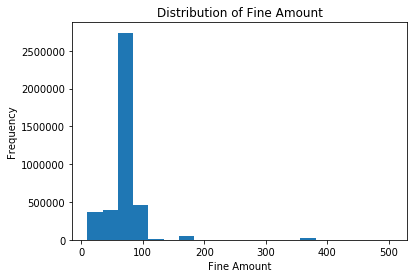

In [74]:
df['Fine amount'].plot.hist(bins = 20)
plt.title('Distribution of Fine Amount')
plt.xlabel('Fine Amount')
plt.show()

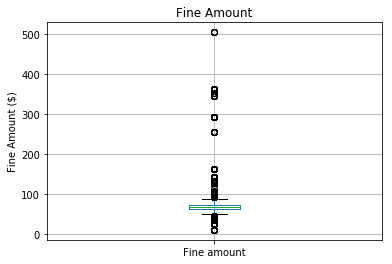

In [75]:
df[['Fine amount']].boxplot()
plt.ylabel('Fine Amount ($)')
plt.title('Fine Amount')
plt.show()

In [76]:
## Look at outlier
print('There are a total of {} outliers'.format((df['Fine amount'] >400).sum()))
df.loc[(df['Fine amount'] > 400), 
       ['Agency', 'Violation code', 'Violation Description', 'Fine amount']]

There are a total of 6 outliers


,Agency,Violation code,Violation Description,Fine amount
374673,WESTERN,558,FOR SALE SIGN,505.0
1240359,WESTERN,558,FOR SALE SIGN,505.0
1240361,WESTERN,558,FOR SALE SIGN,505.0
1664813,WESTERN,558,FOR SALE SIGN,505.0
1664820,WESTERN,558,FOR SALE SIGN,505.0
1674123,WESTERN,558,FOR SALE SIGN,505.0


In [77]:
## Things look fine. Violatin code 558 is the most expensive FOR SALE SIGN ticket
df[df['Violation Description'] == 'FOR SALE SIGN']\
    .groupby('Violation code')['Fine amount']\
    .agg(['min','mean', 'max', 'count'])

,min,mean,max,count
Violation code,,,,
556,105.0,105.0,105.0,239
557,255.0,255.0,255.0,11
558,505.0,505.0,505.0,6
8755,105.0,108.0,255.0,50


In [80]:
## Check some missing values 
tmp = df[df['Fine amount'].isna()]\
    .groupby(['Violation code', 'Violation Description'])\
    .size().sort_values()[::-1]\
    .reset_index()
tmp[tmp['Violation Description'] != 'UNKNOWN'].head(10)

,Violation code,Violation Description,0
0,000,LOAD/UNLOAD ONLY,832
1,80692,COMM VEH OVER TIME LIMIT,714
2,000,TRAILER COMM/22 FT,545
3,000,PARKED IN POSTED AREA,265
4,000,PARKED ON PRIVATE PROPERTY,214
7,80713,PARKED ON FRONT YARD,83
12,000,DISPLAY OF PLATES,40
23,000,NO EVIDENCE OF REG,14
59,000,PARKED IN ELEC VEHIC,4
73,8056E4,RED ZONE,3


In [81]:
## Get the list of violation description that has NA except for UNKNOWN
fine_miss = np.setdiff1d(tmp['Violation Description'].unique(), np.array(['UNKNOWN']))
fine_miss

array(['18 IN/CURB/2 WAY', 'ADVERTISING ON VEH', 'BLOCKING INTERSECTION',
       'CATERING VIOLATION', 'COMM VEH OVER TIME LIMIT',
       'DISABLED PARKING/REFUSE ID', 'DISPLAY OF PLATES', 'DOUBLE PARKING',
       'EXCEED 72 HOURS', 'FOR SALE SIGN', 'LOAD/UNLOAD ONLY',
       'NO EVIDENCE OF REG', 'NO PARK', 'NO PARK/STREET CLEAN',
       'PARK OVERSIZED', 'PARKED IN ELEC VEHIC', 'PARKED IN POSTED AREA',
       'PARKED ON FRONT YARD', 'PARKED ON PRIVATE PROPERTY',
       'PARKED ON SIDEWALK', 'RED ZONE', 'TRAILER COMM/22 FT',
       'TRAILER PARKING UNHITCHED', 'WRG SD/NOT PRL'], dtype=object)

In [82]:
## Summary Function
def sum_fun(x):
    d = {}
    d['median'] = x['Fine amount'].median()
    d['mean'] = x['Fine amount'].mean()
    d['count'] = x.size ## Use for weighting when filling nan
    return pd.Series(d, index = ['median', 'mean', 'count'])
## Create a lookup table of fine amount by violation code and violation decription
## Select violation that contain fine amount missing
lookup_v_fine = df[df['Violation Description'].isin(fine_miss)]\
                    .groupby(['Violation code', 'Violation Description'])\
                    .apply(sum_fun).reset_index()

In [83]:
lookup_v_fine.head(3)

,Violation code,Violation Description,median,mean,count
0,000,18 IN/CURB/2 WAY,NaN,NaN,38.0
1,000,DISABLED PARKING/REFUSE ID,NaN,NaN,19.0
2,000,DISPLAY OF PLATES,NaN,NaN,760.0


In [84]:
## fill lookup table's NaN 
lookup_miss = lookup_v_fine['median'].isna()
result_fill = [] ## store lookup
for index, row in lookup_v_fine[lookup_miss].iterrows():
    des = row['Violation Description'] 
    ## Get value base on size 
    d = lookup_v_fine[lookup_v_fine['Violation Description'] == des] ## dataframe
    if d.shape[0] == 1: ## only 1 match when all values were nan
        result_fill.append(d['median'])
        continue
    idx_max = (d['median'] * d['count']).idxmax ## find most common value
    result_fill.append(d.loc[idx_max, 'median'])
## fill nan
lookup_v_fine.loc[lookup_miss, 'median'] = result_fill
## If cannot find matches then fillna with -1
lookup_v_fine.fillna(value = -1, inplace=True)

## wrap up 
del lookup_miss, result_fill, des, d, idx_max

In [85]:
lookup_v_fine.head(3)

,Violation code,Violation Description,median,mean,count
0,000,18 IN/CURB/2 WAY,63.0,-1.0,38.0
1,000,DISABLED PARKING/REFUSE ID,363.0,-1.0,19.0
2,000,DISPLAY OF PLATES,25.0,-1.0,760.0


In [86]:
## Export lookup table
lookup_v_fine.to_csv('dataset/lookup_v_fine.csv')
## Median and mean looks consistent and using median to keep fine amount 
## as nice round numbers and consistent amount gradient

In [87]:
## Set multi-index for efficient search
lookup_v_fine.set_index(['Violation code', 'Violation Description'], inplace = True)

In [88]:
## Find missing index that are not UNKNOWN
ind_miss = df['Fine amount'].isna() & df['Violation Description'].isin(fine_miss)
result_impute = [] ## store lookup result
## Use lookup table to get a list back where I can replace na with the list
for index, row in df.loc[ind_miss, ['Violation code', 'Violation Description']].iterrows():
    ## Need to find if there is a violation code match first and then rely on description
    code = row['Violation code']
    des = row['Violation Description']
    result_impute.append(lookup_v_fine.loc[(code, des), 'median'])

## Impute missing values
df.loc[ind_miss, 'Fine amount'] = result_impute
print('Current fine amount missing: {}'.format(df['Fine amount'].isna().sum()))
## Replace all na with -1 for unkown
df['Fine amount'].fillna(value = -1, inplace = True)
print('End result nan: {}'.format(df['Fine amount'].isna().sum()))
## Downgrade value 
df['Fine amount'] = pd.to_numeric(df['Fine amount'], downcast = 'integer')

## wrap up
del ind_miss, result_impute, code, des, fine_miss

Current fine amount missing: 1568
End result nan: float64


## Route

In [226]:
df['Route'].unique().size

5669

## Data Compression

In [222]:
## Convert column into integer
df['Issue time'] = pd.to_numeric(df['Issue time'], downcast = 'integer')

In [223]:
## Convert column into integer
df['Marked Time'] = pd.to_numeric(df['Marked Time'], downcast = 'integer')

In [224]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4038226 entries, 0 to 4038225
Data columns (total 19 columns):
Ticket number            uint64
Issue Date               datetime64[ns]
Issue time               int16
Meter Id                 object
Marked Time              int16
RP State Plate           object
Plate Expiry Date        datetime64[ns]
VIN                      object
Make                     object
Body Style               object
Color                    object
Location                 object
Route                    object
Agency                   category
Violation code           object
Violation Description    object
Fine amount              int16
Latitude                 float64
Longitude                float64
dtypes: category(1), datetime64[ns](2), float64(2), int16(3), object(10), uint64(1)
memory usage: 2.4 GB


## Import/Export

In [91]:
## This is slightly more compact
df.to_pickle('dataset/dataframe.pickle')
## Export current dataframe
# with open('dataset/dataframe.pickle', 'wb') as f:
#     pickle.dump(df, f)

In [219]:
## To be consistent
df = pd.read_pickle('dataset/dataframe.pickle')
## Import pickle in 
# with open('dataset/dataframe.pickle', 'rb') as f:
#     df = pickle.load(f)

In [90]:
??pd.read_pickle

TODO: 
* change the names of the columns for easier usage
* export pandas data for later processsing
* compress the data as much as possible
* Redo Meter time. Convert to time column
* day1['time'] = pd.to_datetime(day1['time'], format='%H:%M').dt.time

random testing

In [ ]:
np.iinfo('int8')

In [ ]:
np.iinfo('uint32')

In [ ]:
np.iinfo(1107434506)

In [ ]:
np.iinfo('uint8')

In [ ]:
# plotly.offline.iplot({"data": [{"x": [1, 2, 3],"y": [4, 10, 5]}],"layout": {"title": "hello world"}},
#                     config={'displayModeBar': False, 'showLink': False}, 
#                     image_width=50, image_height=50)